In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

from siv import SiV
from cavity import Cavity, CavitySiV

plt.rcParams['font.size'] = 18

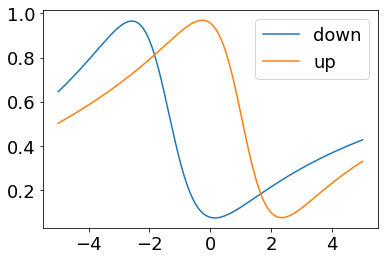

In [3]:
# Values taken from fitting notebook SSR Rabi.nb
c = Cavity({
            "w_down" : -2.53141,       
            "g_down" : 5.82265,       
            "gamma_down" : 0.1,   

            "w_up" : -0.205697,          
            "g_up" : 6.15004,         
            "gamma_up" : 0.1,    

            "w_c" : -12.6126,    
            "k_in" : 12.2252, 
            "k_tot" : 33.0766, 
})

w_arr = np.linspace(-5, 5, 1000)
plt.plot(w_arr, c.reflectance(w_arr, 0), label="down")
plt.plot(w_arr, c.reflectance(w_arr, 1), label="up")
plt.legend()

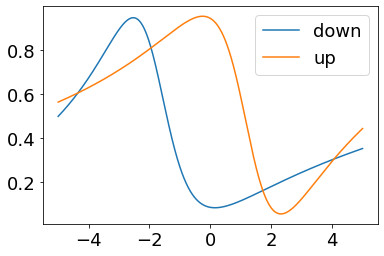

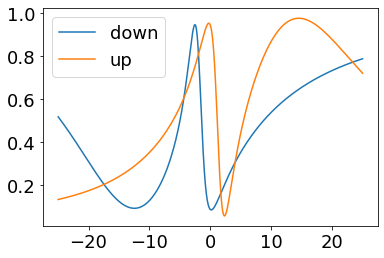

In [4]:
# Function and values taken from fitting notebook SSR Rabi (Mihir Bhaskar's conflicted copy 2019-03-20).nb
def t_function(w, w_a, delta, g, gamma, k, alpha, phi, B):
    t = np.sqrt(k) / (1j * (w - w_a - delta) + (k / 2) + g ** 2 / (1j * (w - w_a) + (gamma / 2))) + alpha * np.exp(1j * phi)
    return B * (t * t.conjugate()).real

w_arr = np.linspace(-5, 5, 1000)
plt.plot(w_arr, t_function(w=w_arr, w_a=-2.61589, delta=-8.56955, g=5.27, gamma=0.1, k=33.1, alpha=-0.26693, phi=-0.0636794, B=14.3136), label="down")
plt.plot(w_arr, t_function(w=w_arr, w_a=2.03911, delta=7.77476, g=5.27, gamma=0.1, k=33.1, alpha=-0.115794, phi=2.39099, B=4.95673), label="up")
plt.legend()

plt.figure()
w_arr = np.linspace(-25, 25, 1000)
plt.plot(w_arr, t_function(w=w_arr, w_a=-2.61589, delta=-8.56955, g=5.27, gamma=0.1, k=33.1, alpha=-0.26693, phi=-0.0636794, B=14.3136), label="down")
plt.plot(w_arr, t_function(w=w_arr, w_a=2.03911, delta=7.77476, g=5.27, gamma=0.1, k=33.1, alpha=-0.115794, phi=2.39099, B=4.95673), label="up")
plt.legend()

### Trial random plots

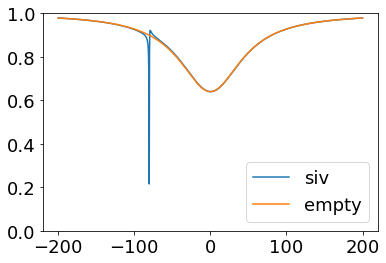

In [5]:
c = Cavity({
            "w_down" : -80,       
            "g_down" : 5.82265,       
            "gamma_down" : 0.1,
    
            "w_up" : -0.205697,          
            "g_up" : 0,         
            "gamma_up" : 0.1,    
            "w_c" : 0,    
    
            "k_in" : 90, 
            "k_tot" : 100, 
})

plt.figure()
w_arr = np.linspace(-200, 200, 2000)
plt.plot(w_arr, c.reflectance(w_arr, 0), label="siv")
plt.plot(w_arr, c.reflectance(w_arr, 1), label="empty")
plt.ylim([0, 1])
plt.legend()

# SiV Class Energy Plotting Test

Ground state splitting at 0 field is 98.6


D:\Qi\Documents\Research\Codes\cQED Model\siv.py:276: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


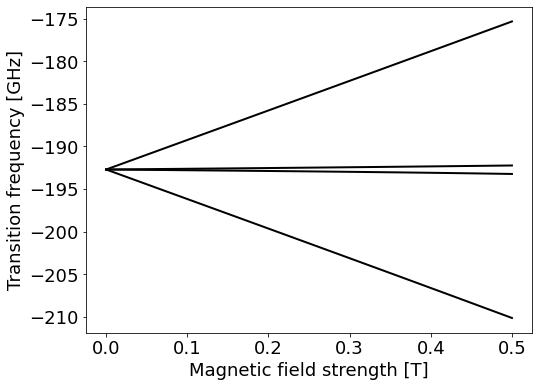

In [8]:
s = SiV(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
# s = SiV()

# Sweep across B field strength for a given axis 
B_axis = np.array([1, 0, 0])
B_strength_sweep = np.linspace(0, 0.5, 40)

# (3 x N)-shaped arary for the set of B-field vectors in sweep
B_sweep = np.outer(B_strength_sweep, B_axis).T
bands, states = s.sweep_B_field_eigenenergies(B_sweep, plot=False) # Compute energies
s.sweep_B_field_transitions(B_sweep, frozen=True)

# Ground state splitting at 0 field: used as a characterisation of strain value
delta_gs = bands[0, 0, -1] - bands[0, 0, 0]
print("Ground state splitting at 0 field is {:.3}".format(delta_gs)) 

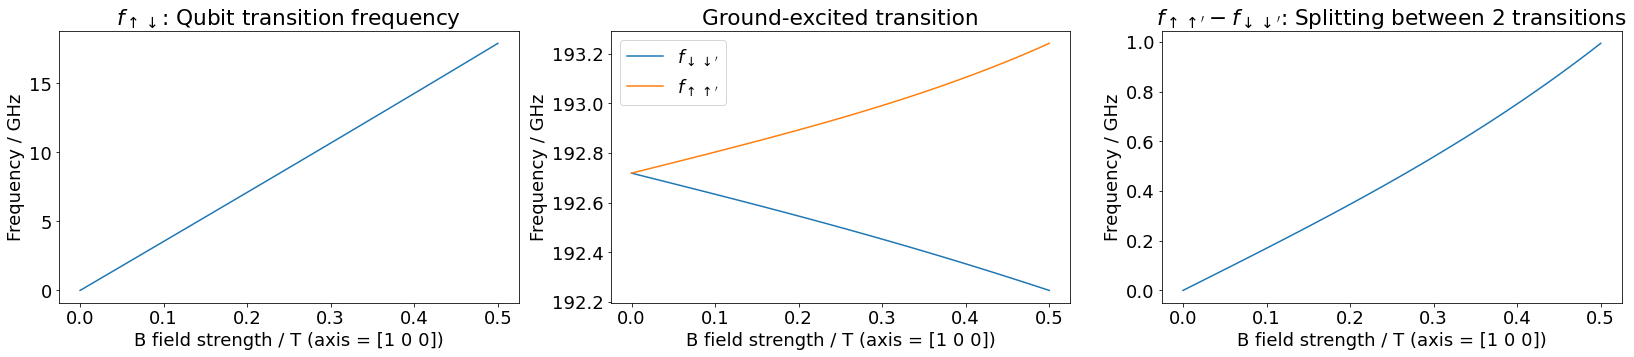

In [9]:
plt.figure(figsize=[28, 5])

# Ground-ground spin transition between lowest and 2nd-lowest
gg_up_down = bands[0, :, 1] - bands[0, :, 0]
plt.subplot(1, 3, 1)
plt.title("$f_{\\uparrow\\downarrow}$: Qubit transition frequency")
plt.xlabel("B field strength / T (axis = {})".format(B_axis))
plt.ylabel("Frequency / GHz")
plt.plot(B_strength_sweep, gg_up_down)

# Ground-excited transition between lowest-lowest and 2nd-2nd bands (down-down, up-up)
ge_down_down = bands[0, :, 0] - bands[1, :, 0]
ge_up_up = bands[0, :, 1] - bands[1, :, 1]
plt.subplot(1, 3, 2)
plt.title("Ground-excited transition")
plt.xlabel("B field strength / T (axis = {})".format(B_axis))
plt.ylabel("Frequency / GHz")
plt.plot(B_strength_sweep, ge_down_down, label="$f_{\\downarrow\\downarrow'}$")
plt.plot(B_strength_sweep, ge_up_up, label="$f_{\\uparrow\\uparrow'}$")
plt.legend()

# Ground-excited transition difference between lowest-lowest and 2nd-2nd bands (up-up minus down-down)
plt.subplot(1, 3, 3)
plt.title("$f_{\\uparrow\\uparrow'} - f_{\\downarrow\\downarrow'}$: Splitting between 2 transitions")
plt.xlabel("B field strength / T (axis = {})".format(B_axis))
plt.ylabel("Frequency / GHz")
plt.plot(B_strength_sweep, ge_up_up - ge_down_down)

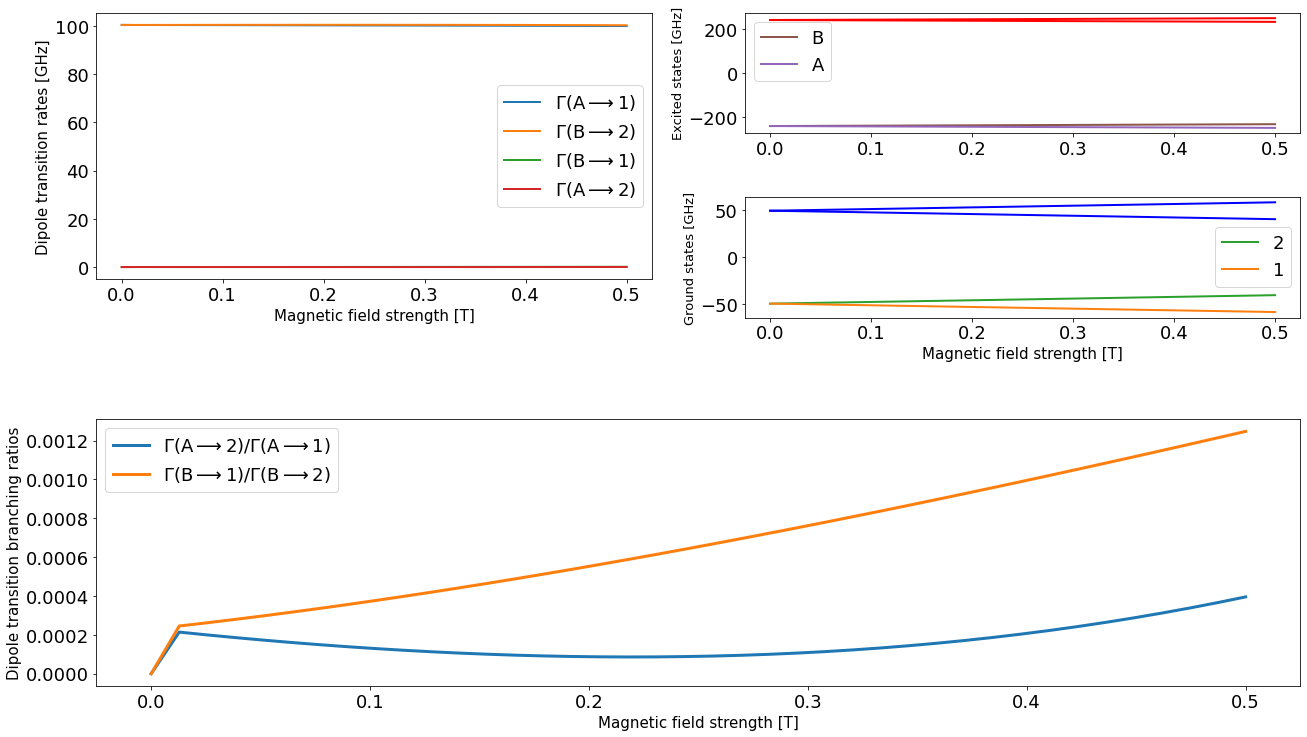

B axis = [1 0 0]


In [10]:
s.dipole_transitions(B_sweep)
print("B axis = {}".format(B_axis))

# Parameter optimization to maximize contrast

## Primitive optimization - sweep over parameters by hand

### Sweep only B field along x-axis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

from siv import SiV
from cavity import Cavity, CavitySiV

plt.rcParams['font.size'] = 18

Maximum contrast = 0.279 located at frequency 1.13
Lower reflectivity = 0.46, higher reflectivity = 0.251
Applied field = 0.5, detuning = -16.5


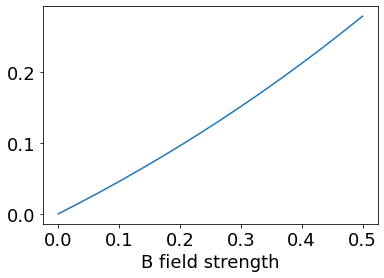

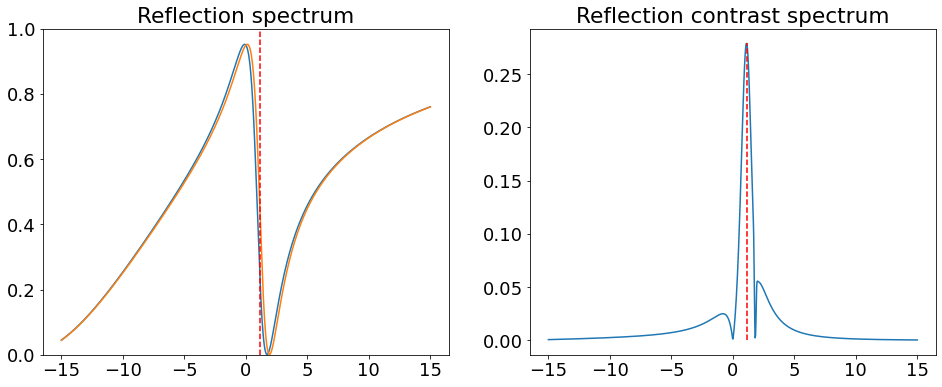

In [6]:
# Strain = 0
s = SiV()
c = CavitySiV(siv=s)

delta = -0.5 * 33 # Fixed value here for now

# Sweep over this range of B
B_arr = np.linspace(0, 0.5, 16)
B_axis = np.array([0, 0, 1])

# Get the contrast for each value of B, Here the max in max_contrast refers to the max value within each 
# spectrum (i.e. at a particular point of freq), and does not refer to the max across B field values.
contrast = np.array([c.max_contrast(B, delta, B_axis) for B in B_arr])

plt.plot(B_arr, contrast)
plt.xlabel("B field strength")
w_arr = np.linspace(-15, 15, 1000)
c.plot_reflection_contrast(w_arr, B_arr[np.argmax(contrast)] * B_axis, delta)
print("Applied field = {:.3}, detuning = {:.3}".format(B_arr[np.argmax(contrast)], delta))

Maximum contrast = 3.7 located at frequency 0.796
Lower reflectivity = 0.000978, higher reflectivity = 0.58
Applied field = 0.5, detuning = -16.5


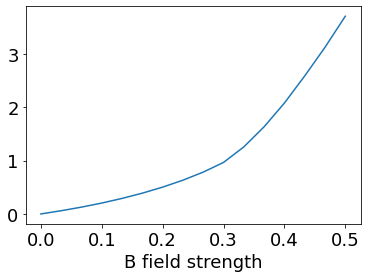

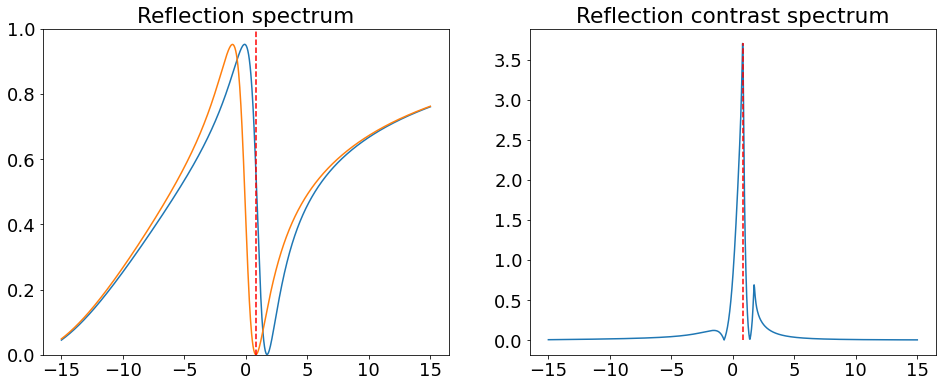

In [7]:
# Strain nonzero
s = SiV(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
c = CavitySiV(siv=s)

w_arr = np.linspace(-15, 15, 1000)
delta = -0.5 * 33 # Fixed value here for now

# Sweep over this range of B
B_arr = np.linspace(0, 0.5, 16)
B_axis = np.array([1, 0, 0])

# Get the contrast for each value of B, Here the max in max_contrast refers to the max value within each 
# spectrum (i.e. at a particular point of freq), and does not refer to the max across B field values.
contrast = np.array([c.max_contrast(B, delta, B_axis) for B in B_arr])

plt.plot(B_arr, contrast)
plt.xlabel("B field strength")
c.plot_reflection_contrast(w_arr, B_arr[np.argmax(contrast)] * B_axis, delta)
print("Applied field = {:.3}, detuning = {:.3}".format(B_arr[np.argmax(contrast)], delta))

### Sweep B field strength and axis

Maximum contrast = 3.7 located at frequency 0.796
Lower reflectivity = 0.000978, higher reflectivity = 0.58
Applied field = 0.5, theta = 1.57, phi = 3.14, axis = [-1.0000000e+00  1.2246468e-16  6.1232340e-17], detuning = -16.5


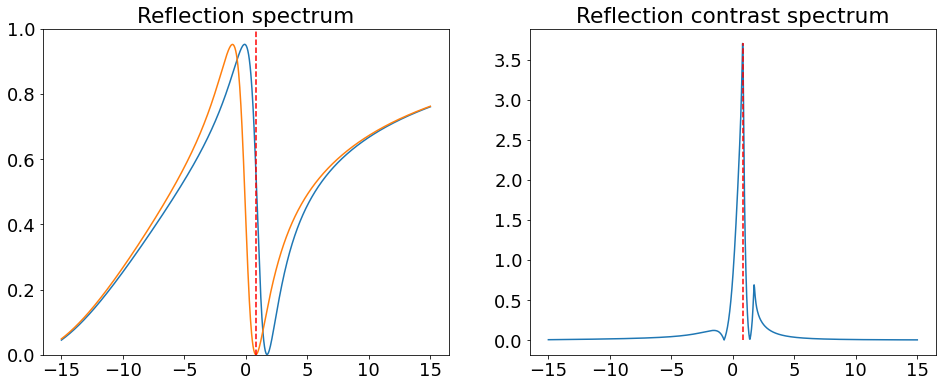

In [8]:
s = SiV(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
c = CavitySiV(siv=s)
delta = -0.5 * 33 # Fixed value here for now

# Sweep over this range of parameters
B_arr = np.linspace(0, 0.5, 16)
theta_arr = np.linspace(0, np.pi, 5)
phi_arr = np.linspace(0, 2 * np.pi, 5)
best_contrast = 0

for B in B_arr:
    for theta in theta_arr:
        for phi in phi_arr:
            B_axis = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
            contrast = c.max_contrast(B, delta, B_axis)
            if contrast > best_contrast:
                best_B, best_theta, best_phi, best_axis = B, theta, phi, B_axis
                best_contrast = contrast

w_arr = np.linspace(-15, 15, 1000)
c.plot_reflection_contrast(w_arr, best_B * best_axis, delta)
print("Applied field = {:.3}, theta = {:.3}, phi = {:.3}, axis = {}, detuning = {:.3}".format(best_B, best_theta, best_phi, best_axis, delta))

## Automated optimization - sweep over B field and detuning

### Unbounded optimization

In [9]:
# Optimize contrast by varying the B field (along x-axis) and detuning
s = SiV(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
c = CavitySiV(siv=s)

opt = minimize(lambda args: -c.max_contrast(args[0], args[1], np.array([1, 0, 0])), x0=[0.1, -15])
B_opt, delta_opt = opt.x
contrast_opt = -opt.fun # Negative since we used minimize()
print("Optimum contrast of {:.3} achieved at B = {:.3} and delta = {:.3}".format(contrast_opt, B_opt, delta_opt))

Optimum contrast of 12.1 achieved at B = 2.39 and delta = -3.49


Maximum contrast = 12.1 located at frequency -7.61
Lower reflectivity = 0.95, higher reflectivity = 2.68e-06


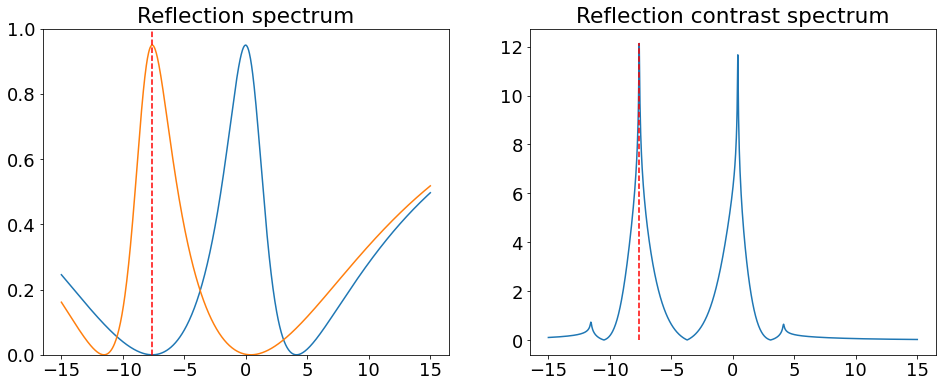

In [10]:
c.plot_reflection_contrast(np.linspace(-15, 15, 1000), [B_opt, 0, 0], delta_opt)

### Bounded optimization

In [16]:
# Optimize contrast by varying the B field (along x-axis) and detuning
s = SiV(alpha_e=125, beta_e=125, alpha_g=20, beta_g=20)
c = CavitySiV(siv=s)

opt = minimize(lambda args: -c.max_contrast(args[0], args[1], np.array([1, 0, 0])), x0=[0.1, -15], bounds=((-0.5, 0.5), (-60, 60)))
B_opt, delta_opt = opt.x
contrast_opt = -opt.fun # Negative since we used minimize()
print("Optimum contrast of {:.3} achieved at B = {:.3} and delta = {:.3}".format(contrast_opt, B_opt, delta_opt))

Optimum contrast of 4.76 achieved at B = 0.5 and delta = -20.1


Maximum contrast = 4.76 located at frequency 0.526
Lower reflectivity = 0.00156, higher reflectivity = 0.768


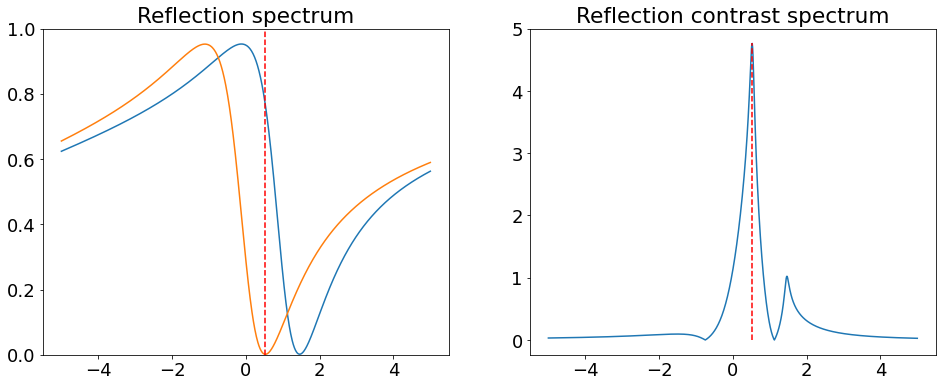

In [17]:
c.plot_reflection_contrast(np.linspace(-5, 5, 1000), [B_opt, 0, 0], delta_opt)